In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from scipy import interpolate
import json

d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\install\anaconda3\envs\anomaly\lib\site-packages\tensorflow\python\framework

In [2]:
normal_pc = np.load("../../data/WADI/normal_pc4.npy")
anomaly_pc = np.load("../../data/WADI/anomaly_pc4.npy")

In [3]:
X_train = np.concatenate((normal_pc, anomaly_pc[:, :-1]))

In [4]:
y_train = np.concatenate((np.zeros(len(normal_pc)), np.ones(len(anomaly_pc))))

In [36]:
random_index = np.random.choice(len(normal_pc)+len(anomaly_pc), (len(normal_pc)+len(anomaly_pc))//5).astype("int")
pd.Series(random_index).describe()

count    2.764800e+05
mean     6.914396e+05
std      3.987706e+05
min      3.000000e+00
25%      3.470552e+05
50%      6.910885e+05
75%      1.037253e+06
max      1.382389e+06
dtype: float64

In [38]:
attack_index = anomaly_pc[:,-1]==1

In [12]:
def get_eval(ground_truth, pred_val):
    assert ground_truth.shape == pred_val.shape
    TP, FP, TN, FN = 0,0,0,0
    gth = ground_truth.ravel()
    pred = pred_val.ravel()
    for i in range(len(gth)):
        if(gth[i] >0.5):
            if(pred[i]>0.5):
                TP+=1
            elif(pred[i]<=0.5):
                FN +=1
        elif(gth[i]<=0.5):
            if(pred[i]>0.5):
                FP +=1
            elif(pred[i]<=0.5):
                TN+=1
    if(TP==0 or FP==0 or FN==0):
        #print("someone=0, TP=", TP, " FP=", FP, ", FN=",FN)
        return (0,0,0)
    pre = TP/(TP+FP)
    rec = TP/(TP+FN)
    F1 = 2*pre*rec/(pre+rec)
    #print("pre: ", pre, ";  rec: ", rec, "; F1: ", F1)
    return (pre, rec, F1)    

In [41]:
model1 = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(X_train.shape[1],input_dim=X_train.shape[1], activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    #tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax), 
    tf.keras.layers.Dense(1, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model1.compile(optimizer="Adam",
              loss=tf.keras.losses.binary_crossentropy,
               metrics=[tf.keras.metrics.BinaryAccuracy(), "accuracy"])
model1.fit(X_train[random_index,:], y_train[random_index], epochs=5)

Epoch 1/5
276480/276480 [==============================] - 19s 70us/sample - loss: 13.9517 - binary_accuracy: 0.1249
Epoch 2/5
276480/276480 [==============================] - 20s 71us/sample - loss: 13.9517 - binary_accuracy: 0.1249
Epoch 3/5
276480/276480 [==============================] - 19s 69us/sample - loss: 13.9517 - binary_accuracy: 0.1249
Epoch 4/5
276480/276480 [==============================] - 19s 69us/sample - loss: 13.9517 - binary_accuracy: 0.1249
Epoch 5/5
276480/276480 [==============================] - 19s 70us/sample - loss: 13.9517 - binary_accuracy: 0.1249


In [44]:
model2 = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(X_train.shape[1],input_dim=X_train.shape[1], activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(100, activation=tf.nn.relu),
    #tf.keras.layers.Dense(200, activation=tf.nn.relu),
    
    #tf.keras.layers.Dense(100, activation=tf.nn.relu),
   # tf.keras.layers.Dense(40, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    #tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax), 
    tf.keras.layers.Dense(1, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model2.compile(optimizer="Adam",
              loss=tf.keras.losses.binary_crossentropy,
               metrics=[tf.keras.metrics.BinaryAccuracy(), "accuracy"])
model2.fit(X_train[random_index,:], y_train[random_index], epochs=5)

Epoch 1/5
276480/276480 [==============================] - 12s 45us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 2/5
276480/276480 [==============================] - 12s 43us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 3/5
276480/276480 [==============================] - 12s 42us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 4/5
276480/276480 [==============================] - 12s 43us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 5/5
276480/276480 [==============================] - 12s 43us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249


In [45]:
model1 = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(X_train.shape[1],input_dim=X_train.shape[1], activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
     tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
     tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
         tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
     tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    #tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax), 
    tf.keras.layers.Dense(1, activation=tf.nn.softmax)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model1.compile(optimizer="Adam",
              loss=tf.keras.losses.binary_crossentropy,
               metrics=[tf.keras.metrics.BinaryAccuracy(), "accuracy"])
model1.fit(X_train[random_index,:], y_train[random_index], epochs=5)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5
276480/276480 [==============================] - 28s 102us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 2/5
276480/276480 [==============================] - 28s 102us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 3/5
276480/276480 [==============================] - 29s 106us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 4/5
276480/276480 [==============================] - 30s 109us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249
Epoch 5/5
276480/276480 [==============================] - 31s 113us/sample - loss: 13.9517 - binary_accuracy: 0.1249 - acc: 0.1249


In [46]:
model_deep_dropout_sigmoid = tf.keras.models.Sequential([
    #tf.keras.layers.Flatten(input_shape=(sample_size,dimension)),
    tf.keras.layers.Dense(X_train.shape[1],input_dim=X_train.shape[1], activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
     tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(200, activation=tf.nn.relu),
     tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
         tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(40, activation=tf.nn.relu),
     tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    #tf.keras.layers.Dense(sample_size*dimension, activation=tf.nn.softmax), 
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
#adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_deep_dropout_sigmoid.compile(optimizer="Adam",
              loss=tf.keras.losses.binary_crossentropy,
               metrics=[tf.keras.metrics.BinaryAccuracy(), "accuracy"])
model_deep_dropout_sigmoid.fit(X_train[random_index,:], y_train[random_index], epochs=5)

Epoch 1/5
276480/276480 [==============================] - 30s 109us/sample - loss: 0.0573 - binary_accuracy: 0.9775 - acc: 0.9775
Epoch 2/5
276480/276480 [==============================] - 30s 108us/sample - loss: 0.0143 - binary_accuracy: 0.9951 - acc: 0.9951
Epoch 3/5
276480/276480 [==============================] - 30s 110us/sample - loss: 0.0101 - binary_accuracy: 0.9967 - acc: 0.9967
Epoch 4/5
276480/276480 [==============================] - 30s 108us/sample - loss: 0.0079 - binary_accuracy: 0.9973 - acc: 0.9973
Epoch 5/5
276480/276480 [==============================] - 31s 111us/sample - loss: 0.0072 - binary_accuracy: 0.9977 - acc: 0.9977


In [50]:
y_pred = model_deep_dropout_sigmoid.predict(X_train).ravel()

print("y_pred.shape", y_pred.shape)

y_pred.shape (1382402,)


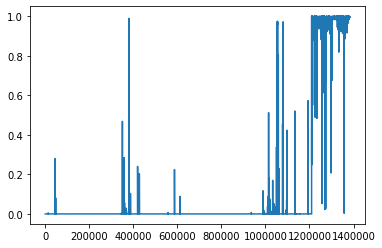

In [51]:
plt.plot(y_pred)

In [55]:
def eval_model(model):
    
    print("clf mean on 14days", 1 - np.mean(y_pred[:normal_pc.shape[0]]))
    print("corr on 2days", np.corrcoef(y_pred[normal_pc.shape[0]:], anomaly_pc[:,-1]))
    res = {}
    res["F1"]=[]
    res["rec"]=[]
    res["pre"]=[]
    for th in np.arange(0.01,1,0.1):
        y_pred_th = np.array([1 if y_pred[i] > th else 0 for i in \
                     range(len(y_pred))])
        print("On 14days:", 1 - np.mean(y_pred_th[:normal_pc.shape[0]]))
        pre,rec,f1 = get_eval(np.array(y_pred_th[normal_pc.shape[0]:]), anomaly_pc[:,-1])
        res["F1"].append(f1)
        res["rec"].append(rec)
        res["pre"].append(pre)
    return res
        

In [56]:
res = eval_model(model1)
print(np.max(res["F1"]))

clf mean on 14days 0.9988376628607512
corr on 2days [[ 1.         -0.03301684]
 [-0.03301684  1.        ]]
On 14days: 0.9964442820401107
On 14days: 0.9979993402783232
On 14days: 0.9983316812734117
On 14days: 0.9985524152179107
On 14days: 0.9987326399366403
On 14days: 0.9989492402866731
On 14days: 0.999150132977734
On 14days: 0.9993138233185984
On 14days: 0.9994766869405697
On 14days: 0.9997569446453831
0.11343408070764606
